In [812]:
import glob
import scipy
import os,sys
import zipfile
import numpy as np
import nibabel as nib
import tensorflow as tf
from scipy import ndimage
from tensorflow import keras
from natsort import natsorted
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from aifnet_utils.preprocess import read_nifti_file, normalize, normalize_aif, process_scan, normalize_zero_one
from aifnet_utils.data_loaders import read_isles_volumepaths_from_file_otf, read_isles_annotations_from_file, ISLES18DataGen_aifvof_otf
from aifnet_utils.data_loaders import delay_sequence_padding, anticipate_sequence_padding, late_bolus, early_bolus
from aifnet_utils.results import plot_predictions
from aifnet_utils.losses import MaxCorrelation
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from scipy.linalg import convolution_matrix, toeplitz, circulant
from sklearn.linear_model import Ridge
from matplotlib import pyplot, image, transforms
from scipy import ndimage
from numpy import inf
import random

%matplotlib inline

!pwd

/home/sebastian/experiments/aifnet_replication


In [2]:
#Reading an example PCT volume

In [28]:

keras.backend.set_image_data_format('channels_last')
ROOT_EXP = '/home/sebastian/experiments/aifnet_replication/'
root_dir     = '/media/sebastian/data/ASAP/ISLES2018_Training'
current_fold = 1
#At insel: /media/sebastian/data/ASAP/ISLES2018_Training
#Local: '/Users/sebastianotalora/work/postdoc/data/ISLES/'
aif_annotations_path = ROOT_EXP + 'annotated_aif_vof_complete_revised.csv'
min_num_volumes_ctp = 43

#Reading AIFs and VOFs for each of the partitions
train_partition_path = ROOT_EXP+'/partitions/fold_'+str(current_fold) +'/train.txt'
valid_partition_path = ROOT_EXP+'/partitions/fold_'+str(current_fold) +'/valid.txt'
test_partition_path =  ROOT_EXP+'/partitions/fold_'+str(current_fold) +'/test.txt'

aif_annotations_train, vof_annotations_train = read_isles_annotations_from_file(aif_annotations_path, train_partition_path, 
                                                root_dir, min_num_volumes_ctp, return_aif_only = False)
aif_annotations_valid, vof_annotations_valid = read_isles_annotations_from_file(aif_annotations_path, valid_partition_path, root_dir, 
                                        min_num_volumes_ctp, return_aif_only = False)
aif_annotations_test, vof_annotations_test = read_isles_annotations_from_file(aif_annotations_path,  test_partition_path,
                                        root_dir, min_num_volumes_ctp, return_aif_only = False)

ctp_volumes_train = read_isles_volumepaths_from_file_otf(root_dir, train_partition_path, aif_annotations_path)
ctp_volumes_valid = read_isles_volumepaths_from_file_otf(root_dir, valid_partition_path, aif_annotations_path)
ctp_volumes_test = read_isles_volumepaths_from_file_otf(root_dir, test_partition_path, aif_annotations_path)

print(len(ctp_volumes_train), len(aif_annotations_train))
print(len(ctp_volumes_valid), len(aif_annotations_valid))
print(len(ctp_volumes_test), len(aif_annotations_test))



64 64
9 9
21 21


In [38]:
train_datagen = ISLES18DataGen_aifvof_otf(ctp_volumes=ctp_volumes_train, annotations_aif=aif_annotations_train,
                            annotations_vof=vof_annotations_train,minimum_number_volumes_ctp = 43, batch_size=1,
                                        time_arrival_augmentation = True, delay_t=0)


In [392]:
example_id = 4
sample_pct = train_datagen.__getitem__(example_id)
pct_vals = sample_pct[0][0,:,:,:,:]
vascular_functions = sample_pct[1]
aif = vascular_functions[0]
vof = vascular_functions[1]

In [398]:
pct_vals.shape

(256, 256, 8, 43)

In [397]:
train_datagen.ctp_volumes[4]

{'image': '/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_9/SMIR.Brain.XX.O.CT_4DPWI.345617/SMIR.Brain.XX.O.CT_4DPWI.345617.nii'}

In [393]:
np.mean(pct_vals[:,:])

0.100462556

In [394]:
mu_voi = np.array([np.mean(pct_vals[:,:,:,i]) for i in range(pct_vals.shape[-1])])
print(mu_voi)
mu_voi.shape

[0.09578845 0.09495974 0.09517275 0.09572373 0.09533498 0.09555141
 0.09587318 0.09666179 0.09762696 0.09871678 0.10005605 0.10162223
 0.10293127 0.10433733 0.10530403 0.10639723 0.10669024 0.10721796
 0.10666063 0.10597348 0.1047614  0.10390548 0.1028347  0.10203261
 0.10077129 0.10058642 0.10010765 0.09977733 0.09974369 0.09959289
 0.09980762 0.09972574 0.1008834  0.09959068 0.09939089 0.09967302
 0.09949636 0.10010714 0.09954894 0.10015012 0.09967422 0.09960089
 0.09953106]


(43,)

Text(0, 0.5, 'Normalized Density (HU)')

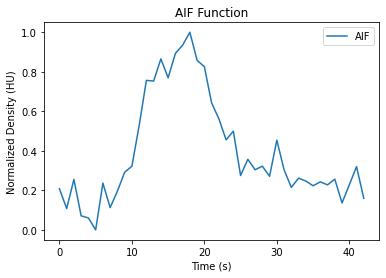

In [494]:
plt.title('AIF Function')        
y = normalize_zero_one(aif)
y_p = normalize_zero_one(vof)
plt.plot(aif)
#plt.plot(y_p)
#plt.plot(mu_voi)
plt.legend(['AIF','VOF', 'mu_VOI'])
plt.xlabel('Time (s)')
plt.ylabel('Normalized Density (HU)')


In [123]:
A = np.multiply(np.tril(np.ones((aif.shape[0],aif.shape[0]))), circulant(aif))

In [550]:
A

array([[0.20844314, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.10814934, 0.20844314, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.25565047, 0.10814934, 0.20844314, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.22772419, 0.13637172, 0.2569182 , ..., 0.20844314, 0.        ,
        0.        ],
       [0.32032421, 0.22772419, 0.13637172, ..., 0.10814934, 0.20844314,
        0.        ],
       [0.1597135 , 0.32032421, 0.22772419, ..., 0.25565047, 0.10814934,
        0.20844314]])

In [551]:
aif

array([0.20844314, 0.10814934, 0.25565047, 0.07106612, 0.06069719,
       0.        , 0.23661348, 0.11289841, 0.19587054, 0.29150642,
       0.32214496, 0.52712812, 0.75657056, 0.75305812, 0.86538566,
       0.76932955, 0.89272087, 0.93473004, 1.        , 0.85739599,
       0.82589773, 0.64256241, 0.56272821, 0.45587847, 0.49946468,
       0.27529467, 0.35701626, 0.30433941, 0.32254093, 0.27124781,
       0.45400643, 0.30449034, 0.21549428, 0.26170131, 0.24740749,
       0.22339988, 0.24322976, 0.22796416, 0.2569182 , 0.13637172,
       0.22772419, 0.32032421, 0.1597135 ])

In [552]:
u, s, vh = np.linalg.svd(A, full_matrices=True)

In [553]:
np.linalg.pinv(A)

array([[ 4.79747143e+00, -7.69162430e-14,  9.26061107e-14, ...,
        -1.61586276e-15,  1.96411336e-15,  4.74064592e-17],
       [-2.48913623e+00,  4.79747143e+00, -9.06323372e-14, ...,
         2.31972568e-15, -1.49271121e-15,  6.53484538e-16],
       [-4.59251101e+00, -2.48913623e+00,  4.79747143e+00, ...,
        -1.07364610e-15, -5.64293465e-16,  6.17735903e-16],
       ...,
       [-5.06382403e+02, -6.10756982e+02,  5.92657357e+02, ...,
         4.79747143e+00, -1.83700447e-13,  9.09357717e-14],
       [ 1.19522094e+03, -5.06382403e+02, -6.10756982e+02, ...,
        -2.48913623e+00,  4.79747143e+00,  3.57527879e-13],
       [ 7.43055630e+02,  1.19522094e+03, -5.06382403e+02, ...,
        -4.59251101e+00, -2.48913623e+00,  4.79747143e+00]])

In [554]:
truncation_vals = 3
S = np.diag(1/s)
S[-truncation_vals:,-truncation_vals:] = 0

In [555]:
A_inv = np.matmul(np.matmul(u,S), vh)

In [571]:
A_inv.shape

(43, 43)

In [556]:
pseudo_inv = scipy.linalg.pinv2(A)

In [557]:
k =  np.matmul(mu_voi,A_inv)

In [558]:
T_max = np.argmax(k)
print(T_max)

26


In [560]:
clf = Ridge(alpha=1.0)
clf.fit(A, mu_voi)
k_tik = clf.predict(A)

Text(0, 0.5, 'Normalized Density (HU)')

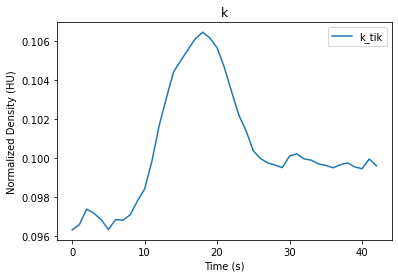

In [561]:
plt.title('k')        
#plt.plot(k)
plt.plot(k_tik)
#plt.plot(mu_voi)
plt.legend(['k_tik'])
plt.xlabel('Time (s)')
plt.ylabel('Normalized Density (HU)')

In [576]:
print(A.shape)
print(k_tik.shape)
print(k_tik.shape)
print(pct_vals.shape)
example_voi = pct_vals[100,100,4,:]
print(example_voi.shape)

(43, 43)
(43,)
(43,)
(256, 256, 8, 43)
(43,)


Text(0, 0.5, 'Normalized Density (HU)')

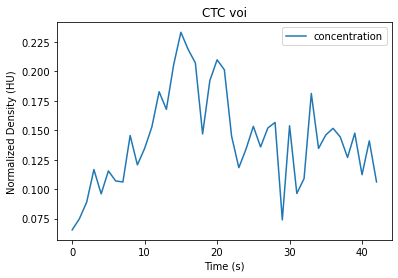

In [578]:
plt.title('CTC voi')        
#plt.plot(k)
plt.plot(example_voi)
#plt.plot(mu_voi)
plt.legend(['concentration'])
plt.xlabel('Time (s)')
plt.ylabel('Normalized Density (HU)')

Text(0, 0.5, 'Normalized Density (HU)')

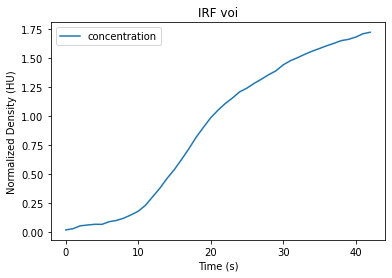

In [583]:
plt.title('IRF voi')        
#plt.plot(k)
plt.plot(np.matmul(A,k_tik))
#plt.plot(mu_voi)
plt.legend(['concentration'])
plt.xlabel('Time (s)')
plt.ylabel('Normalized Density (HU)')


In [585]:
1/example_voi

array([15.284478 , 13.344047 , 11.247273 ,  8.570762 , 10.413283 ,
        8.657365 ,  9.344879 ,  9.421625 ,  6.8674026,  8.286628 ,
        7.428526 ,  6.537939 ,  5.4717517,  5.958294 ,  4.8662276,
        4.286682 ,  4.5707283,  4.8260818,  6.8075604,  5.2013683,
        4.7651577,  4.9650817,  6.896822 ,  8.454784 ,  7.4506826,
        6.519868 ,  7.3593345,  6.5804563,  6.382733 , 13.523207 ,
        6.498978 , 10.377644 ,  9.170745 ,  5.5159483,  7.4277735,
        6.845138 ,  6.592494 ,  6.929833 ,  7.878027 ,  6.7755857,
        8.9036   ,  7.089531 ,  9.419393 ], dtype=float32)

In [590]:
np.max(np.matmul(A,k_tik)/(1/example_voi))

0.27752385575432964

Text(0, 0.5, 'Normalized Density (HU)')

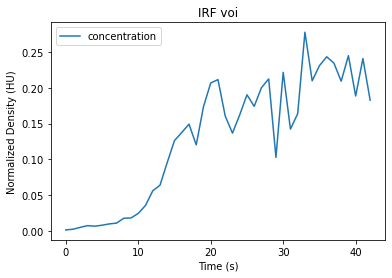

In [589]:
plt.title('IRF voi')        
#plt.plot(k)
plt.plot(np.matmul(A,k_tik)/(1/example_voi))
#plt.plot(mu_voi)
plt.legend(['concentration'])
plt.xlabel('Time (s)')
plt.ylabel('Normalized Density (HU)')


In [765]:
CBFs = np.zeros((pct_vals.shape[0],pct_vals.shape[1],pct_vals.shape[2]))
for cur_slice in range(CBFs.shape[2]):
    for i in range(CBFs.shape[0]):
        for j in range (CBFs.shape[1]):
            voi = pct_vals[i,j,cur_slice:]
            CBFs[i,j,cur_slice] = np.max(np.multiply(np.matmul(A,k),voi))

0.1134332966368203


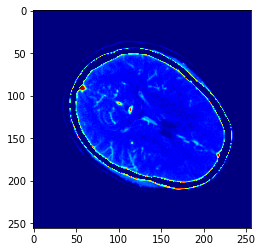

In [808]:
#tr = transforms.Affine2D().rotate_deg(50)
selected_slice = 7
img = CBFs[:,:,selected_slice]
img[img == np.max(img)] =0
print(np.max(img))
#pp = img>0.005
rotated_img = ndimage.rotate(img, 45*60)
plt.imshow(np.array(img*255,dtype = 'uint8'),cmap=plt.cm.jet)
#plt.imshow(, transform=tr)

In [795]:
256**2

65536

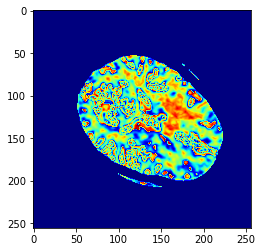

In [811]:
gt_cbf_path ='/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_9/SMIR.Brain.XX.O.CT_CBF.345619/SMIR.Brain.XX.O.CT_CBF.345619.nii'
gt_cbf = nib.load(gt_cbf_path).get_fdata()
plt.imshow(np.array(gt_cbf[:,:,selected_slice]*255,dtype = 'uint8'),cmap=plt.cm.jet)

In [707]:
np.min(gt_cbf[:,:,selected_slice])

0.0

In [784]:
np.max(gt_cbf[:,:,selected_slice])

4402.0

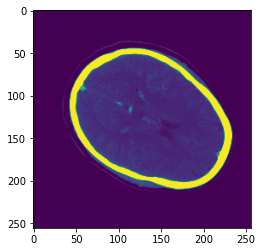

In [696]:
slice_7 = CBFs[:,:,7]
#slice_7[slice_7>1] = 0
rotated_img = ndimage.rotate(slice_7, 0)
plt.imshow(rotated_img)


In [ ]:
#%Calculate the CBF map
#cbfmap = scaling_factor * squeeze(max(rmap));


In [562]:
CBF = np.multiply(np.max(k_tik), 1/pct_vals)

In [563]:
pct_vals[pct_vals==0] = 0.000001

In [564]:
np.max(1/pct_vals[:,:,4])

1000000.0

In [565]:
CBF[CBF == inf] = 0

In [566]:
np.sum(CBF[:,:,0,:])

189016130000.0

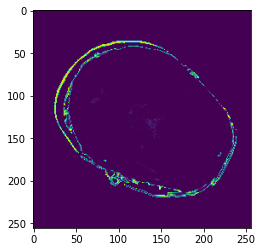

In [567]:
CBF_agregated = CBF.sum(axis=3)
normalized_CBF = normalize_zero_one(CBF_agregated)
normalized_CBF[normalized_CBF==1] = 0
normalized_CBF[normalized_CBF==0.28370348] = 0
plt.imshow(np.array(normalize_zero_one(normalized_CBF[:,:,1])*255, dtype='uint8'))

In [568]:
normalize_zero_one(CBF_agregated[:,:,5])

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

In [569]:
np.max(k_tik)

0.10646189112895685

Text(0, 0.5, 'Normalized Density (HU)')

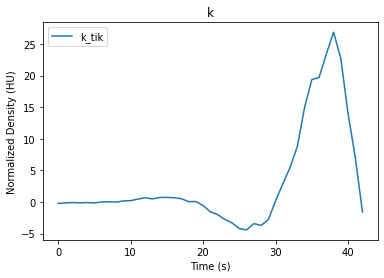

In [572]:
plt.title('k')        
plt.plot(-k)
#plt.plot(k_tik)
#plt.plot(mu_voi)
plt.legend(['k_tik'])
plt.xlabel('Time (s)')
plt.ylabel('Normalized Density (HU)')


Text(0, 0.5, 'Normalized Density (HU)')

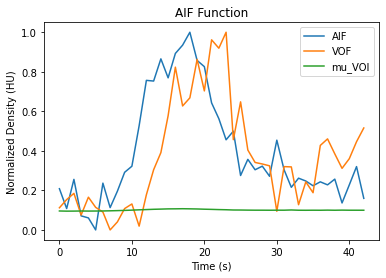

In [548]:
plt.title('AIF Function')        
y = normalize_zero_one(aif)
y_p = normalize_zero_one(vof)
plt.plot(y)
plt.plot(y_p)
plt.plot(mu_voi)
#plt.plot(k)
plt.legend(['AIF','VOF', 'mu_VOI', 'k'])
plt.xlabel('Time (s)')
plt.ylabel('Normalized Density (HU)')


In [279]:
near_I = np.matmul(A,A_inv.T)
#near_I = np.matmul(A,pseudo_inv)

In [280]:
np.allclose(np.eye(near_I.shape[0]),near_I)

True

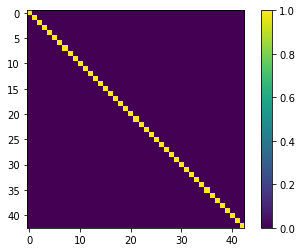

In [281]:
import numpy as np
import matplotlib.pyplot as plt

plt.imshow(near_I)
plt.colorbar()
plt.show()

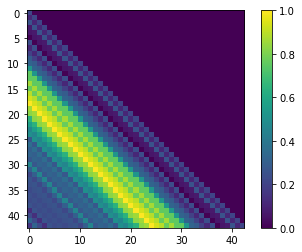

In [284]:
import numpy as np
import matplotlib.pyplot as plt

plt.imshow(A)
plt.colorbar()
plt.show()